In [169]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [170]:
# Define column names
column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 27)]
train_df = pd.read_csv('./dataset/train_FD001.txt', sep='\s+', header=None, names=column_names)
test_df = pd.read_csv('./dataset/test_FD001.txt', sep='\s+', header=None, names=column_names)
true_rul = pd.read_csv('./dataset/RUL_FD001.txt', header=None)

# Notebook Structure

- [Data Preprocessing](#Data-Preprocessing)
    - [Dropping Columns](##Dropping-columns)
    - [Scaling](##Normalization)
    - [Labelling](#data-labelling)
    - [Splitting Training Data (By Engine ID)](#Splitting-Training-Data-For-Validation)
- [Linear Regression](#linear-regression)
    - [Preparing Data with Sliding Window](#Prepping-Data-for-Linear-Regression)
    - [Feature Extraction with TSFRESH](#Feature-Extraction)
    - [Feature Selection with TSFRESH (notWORKING)](#Feature-Selection)
    - [Training Linear Regression](#training)
    - [Validation of Training Data](#Validation)
    - [Predicting on Test Data](#Predict)
- [Other Models](#others)
    - [Preparation of Data](#Data-preparation)
    - [Training](#training)
        - [LSTM](#LSTM)
        - [Bi-LSTM](#Bi-LSTM)
        - [CNN-LSTM](#CNN-LSTM)
    - [Validation](#validation)
        - [LSTM](#validate-lstm)
        - [Bi-LSTM](#validate-bilstm)
        - [CNN-LSTM](#validate-cnnlstm)
    - [Prediction](#prediction)
        - [LSTM](#predict-lstm)
        - [Bi-LSTM](#predict-bilstm)
        - [CNN-LSTM](#predict-cnnlstm)
- [Comparing Models](#Comparison)

# Data Preprocessing

## Dropping columns
- As mentioned during EDA, we will be dropping these columns based on the findings

In [171]:
# Dropping Columns
columns_to_drop = ["setting1", "setting2", "setting3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor22", "sensor23", "sensor24", "sensor25", "sensor26"]
train_df_dropped = train_df.drop(columns=columns_to_drop)
test_df_dropped = test_df.drop(columns=columns_to_drop)

## Normalization

In [172]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Separate the columns to normalize and the columns to skip
columns_to_skip = train_df_dropped.columns[:2]
columns_to_normalize = train_df_dropped.columns[2:]

# Normalize only the selected columns
normalized_data = scaler.fit_transform(train_df_dropped[columns_to_normalize])

# Combine the normalized and unnormalized columns
train_df_normalized = pd.DataFrame(train_df_dropped[columns_to_skip].values, columns=columns_to_skip)
train_df_normalized = pd.concat([train_df_normalized, pd.DataFrame(normalized_data, columns=columns_to_normalize)], axis=1)

# Normalize the test data
test_normalized_data = scaler.transform(test_df_dropped[columns_to_normalize])

# Combine the normalized and unnormalized columns
test_df_normalized = pd.DataFrame(test_df_dropped[columns_to_skip].values, columns=columns_to_skip)
test_df_normalized = pd.concat([test_df_normalized, pd.DataFrame(test_normalized_data, columns=columns_to_normalize)], axis=1)

# Display the normalized DataFrame
print("Normalized Data (0-1 range):")
print(train_df_normalized.head())

Normalized Data (0-1 range):
   engine_id  cycle   sensor2   sensor3   sensor4   sensor7   sensor8  \
0          1      1  0.183735  0.406802  0.309757  0.726248  0.242424   
1          1      2  0.283133  0.453019  0.352633  0.628019  0.212121   
2          1      3  0.343373  0.369523  0.370527  0.710145  0.272727   
3          1      4  0.343373  0.256159  0.331195  0.740741  0.318182   
4          1      5  0.349398  0.257467  0.404625  0.668277  0.242424   

    sensor9  sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  \
0  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986  0.333333   
1  0.100242  0.380952  0.765458  0.279412  0.162813  0.411312  0.333333   
2  0.140043  0.250000  0.795309  0.220588  0.171793  0.357445  0.166667   
3  0.124518  0.166667  0.889126  0.294118  0.174889  0.166603  0.333333   
4  0.149960  0.255952  0.746269  0.235294  0.174734  0.402078  0.416667   

   sensor20  sensor21  
0  0.713178  0.724662  
1  0.666667  0.731014  
2  0.6279

## Data Labelling

In [173]:
# Labelling of Data with RUL and Piecewise
# 1) Labelling RUL
train_df_normalized['RUL'] = train_df_normalized.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# 2) Labelling PWRUL
# Set the early RUL threshold
early_rul_threshold = 120

# Define the piecewise linear degradation function
def piecewise_rul(cycle, max_cycle):
    remaining_life = max_cycle - cycle
    if remaining_life > early_rul_threshold:
        return early_rul_threshold  # slower degradation in the early phase
    else:
        return remaining_life  # direct linear degradation after threshold
    
train_df_normalized["PWRUL"] = train_df_normalized.apply(lambda row: piecewise_rul(row['cycle'], row['cycle'] + row['RUL']), axis=1)

## Splitting Training Data For Validation
- Split is done by engine id

In [174]:
from sklearn.model_selection import train_test_split

# Step 1: Extract Unique Engine IDs
engine_ids = train_df_normalized['engine_id'].unique()

# Step 2: Split Engine IDs into Training and Testing Sets
train_engine_ids, test_engine_ids = train_test_split(
    engine_ids, test_size=0.2, random_state=42
)

# Step 3: Filter Data Based on Engine IDs
train_data = train_df_normalized[train_df_normalized['engine_id'].isin(train_engine_ids)].reset_index(drop=True)
validation_data = train_df_normalized[train_df_normalized['engine_id'].isin(test_engine_ids)].reset_index(drop=True)


## Prepping Data using Sliding Window for LSTM, Bi-LSTM, CNN-LSTM

In [175]:
# Prepping training data
sequence_length = 30

# Identify feature columns
feature_columns = [col for col in train_data.columns if col not in ['engine_id', 'cycle', 'RUL', 'PWRUL']]

# Initialize lists for sequences and labels
X = []
y = []

# Generate sequences and labels
# Sliding window approach
for engine_id in train_data['engine_id'].unique():
    engine_data = train_data[train_data['engine_id'] == engine_id].reset_index(drop=True)
    for i in range(sequence_length, len(engine_data)):
        # Extract sequence of sensor readings
        seq_x = engine_data[feature_columns].iloc[i-sequence_length:i].values
        # Extract the RUL value at the end of the sequence
        seq_y = engine_data['PWRUL'].iloc[i]
        X.append(seq_x)
        y.append(seq_y)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print("Input shape:", X.shape)
print("Labels shape:", y.shape)

Input shape: (14161, 30, 14)
Labels shape: (14161,)


In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional


# Linear Regression

## Prepping Data for Linear Regression
- Sliding Window Approach

In [177]:
feature_dfs = []
label_list = []

# Define the window size (e.g., last 30 cycles)
window_size = 30

# List of Sensors
sensor_list = list(train_df_normalized.columns[2:16])

# For all training and testing data, split to windows of 30, step 1
for engine_id in train_df_normalized['engine_id'].unique():
    engine_data = train_df_normalized[train_df_normalized['engine_id'] == engine_id]
    max_cycle = engine_data['cycle'].max()
    for i in range(window_size, max_cycle + 1):
        window_data = engine_data[(engine_data['cycle'] >= i - window_size) & (engine_data['cycle'] <= i)]
        # Assign unique IDs for tsfresh
        window_data = window_data.copy()
        window_data['id'] = f'{engine_id}_{i}'
        
        # Corrected line: Convert Index to list before concatenation
        columns_to_select = ['id', 'cycle'] + sensor_list
        
        # Append to the list using the corrected columns
        feature_dfs.append(window_data[columns_to_select])
        
        # Get the RUL at this point
        rul = engine_data[engine_data['cycle'] == i]['RUL'].values[0]
        label_list.append({'id': f'{engine_id}_{i}', 'RUL': rul})

tsfresh_input_df = pd.concat(feature_dfs)
tsfresh_input_df.shape

(549561, 16)

In [178]:
# Labels for Linear Regression
labels_df = pd.DataFrame(label_list)

### Feature Extraction for Linear Regression with Tsfresh

In [179]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
extraction_settings = MinimalFCParameters()

extracted_features = extract_features(
    tsfresh_input_df,
    column_id='id',
    column_sort='cycle',
    default_fc_parameters=extraction_settings,
    n_jobs=4
)

Feature Extraction: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


In [180]:
features_labels_df = extracted_features.merge(labels_df, left_index=True, right_on='id')
features_labels_df.head(10)

,sensor2__sum_values,sensor2__median,sensor2__mean,sensor2__length,sensor2__standard_deviation,sensor2__variance,sensor2__root_mean_square,sensor2__maximum,sensor2__absolute_maximum,sensor2__minimum,...,sensor21__mean,sensor21__length,sensor21__standard_deviation,sensor21__variance,sensor21__root_mean_square,sensor21__maximum,sensor21__absolute_maximum,sensor21__minimum,id,RUL
17630,12.590361,0.403614,0.406141,31.0,0.095188,0.009061,0.417146,0.60241,0.60241,0.177711,...,0.568806,31.0,0.080112,0.006418,0.574419,0.683237,0.683237,0.378349,100_100,100
17631,12.647590,0.403614,0.407987,31.0,0.092423,0.008542,0.418324,0.60241,0.60241,0.177711,...,0.569509,31.0,0.080234,0.006438,0.575133,0.683237,0.683237,0.378349,100_101,99
17632,12.777108,0.427711,0.412165,31.0,0.092743,0.008601,0.422470,0.60241,0.60241,0.177711,...,0.564169,31.0,0.085654,0.007337,0.570634,0.683237,0.683237,0.378349,100_102,98
17633,12.861446,0.430723,0.414885,31.0,0.092541,0.008564,0.425081,0.60241,0.60241,0.177711,...,0.557331,31.0,0.091716,0.008412,0.564827,0.683237,0.683237,0.376139,100_103,97
17634,12.816265,0.430723,0.413428,31.0,0.093766,0.008792,0.423928,0.60241,0.60241,0.177711,...,0.558690,31.0,0.090662,0.008220,0.565998,0.683237,0.683237,0.376139,100_104,96
17635,12.912651,0.430723,0.416537,31.0,0.091361,0.008347,0.426439,0.60241,0.60241,0.177711,...,0.557100,31.0,0.089680,0.008042,0.564272,0.683237,0.683237,0.376139,100_105,95
17636,12.825301,0.427711,0.413719,31.0,0.091669,0.008403,0.423753,0.60241,0.60241,0.177711,...,0.555853,31.0,0.089360,0.007985,0.562990,0.683237,0.683237,0.376139,100_106,94
17637,12.710843,0.427711,0.410027,31.0,0.094269,0.008887,0.420724,0.60241,0.60241,0.177711,...,0.550400,31.0,0.087261,0.007614,0.557275,0.683237,0.683237,0.376139,100_107,93
17638,12.539157,0.400602,0.404489,31.0,0.097181,0.009444,0.415999,0.60241,0.60241,0.177711,...,0.557692,31.0,0.092177,0.008497,0.565259,0.727561,0.727561,0.376139,100_108,92
17639,12.515060,0.400602,0.403712,31.0,0.097858,0.009576,0.415402,0.60241,0.60241,0.177711,...,0.562610,31.0,0.094321,0.008896,0.570461,0.727561,0.727561,0.376139,100_109,91


In [181]:
# Drop 'id' and 'RUL' columns to get the feature matrix
X = features_labels_df.drop(['id', 'RUL'], axis=1)

# Target vector
y = features_labels_df['RUL']

### Feature Selection
- Can someone try pca and see the shape difference

In [182]:
from tsfresh import select_features
X_selected = select_features(X, y)

In [183]:
features_labels_df.head()

,sensor2__sum_values,sensor2__median,sensor2__mean,sensor2__length,sensor2__standard_deviation,sensor2__variance,sensor2__root_mean_square,sensor2__maximum,sensor2__absolute_maximum,sensor2__minimum,...,sensor21__mean,sensor21__length,sensor21__standard_deviation,sensor21__variance,sensor21__root_mean_square,sensor21__maximum,sensor21__absolute_maximum,sensor21__minimum,id,RUL
17630,12.590361,0.403614,0.406141,31.0,0.095188,0.009061,0.417146,0.60241,0.60241,0.177711,...,0.568806,31.0,0.080112,0.006418,0.574419,0.683237,0.683237,0.378349,100_100,100
17631,12.647590,0.403614,0.407987,31.0,0.092423,0.008542,0.418324,0.60241,0.60241,0.177711,...,0.569509,31.0,0.080234,0.006438,0.575133,0.683237,0.683237,0.378349,100_101,99
17632,12.777108,0.427711,0.412165,31.0,0.092743,0.008601,0.422470,0.60241,0.60241,0.177711,...,0.564169,31.0,0.085654,0.007337,0.570634,0.683237,0.683237,0.378349,100_102,98
17633,12.861446,0.430723,0.414885,31.0,0.092541,0.008564,0.425081,0.60241,0.60241,0.177711,...,0.557331,31.0,0.091716,0.008412,0.564827,0.683237,0.683237,0.376139,100_103,97
17634,12.816265,0.430723,0.413428,31.0,0.093766,0.008792,0.423928,0.60241,0.60241,0.177711,...,0.558690,31.0,0.090662,0.008220,0.565998,0.683237,0.683237,0.376139,100_104,96


### Splitting the data by engines

In [186]:
# Extract engine IDs from 'id'
features_labels_df['engine_id'] = features_labels_df['id'].apply(lambda x: x.split('_')[0])
features_labels_df['engine_id'] = features_labels_df['engine_id'].astype(int) # cast type to int for masking

# Create masks for training and testing data
train_mask = features_labels_df['engine_id'].isin(train_engine_ids)
test_mask = features_labels_df['engine_id'].isin(test_engine_ids)

# Split the data based on engine
X_train = X_selected[train_mask]
X_test = X_selected[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]


In [187]:
print("Total unique engine IDs:", features_labels_df['engine_id'].nunique())
print("Number of engine IDs in training set:", len(train_engine_ids))
print("Number of engine IDs in testing set:", len(test_engine_ids))
print("Overlap between training and testing IDs:", set(train_engine_ids).intersection(set(test_engine_ids)))

Total unique engine IDs: 100
Number of engine IDs in training set: 80
Number of engine IDs in testing set: 20
Overlap between training and testing IDs: set()


## Training the Linear Regression

In [188]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Validation for Linear Regresssion Model

In [189]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

35.48364409441464

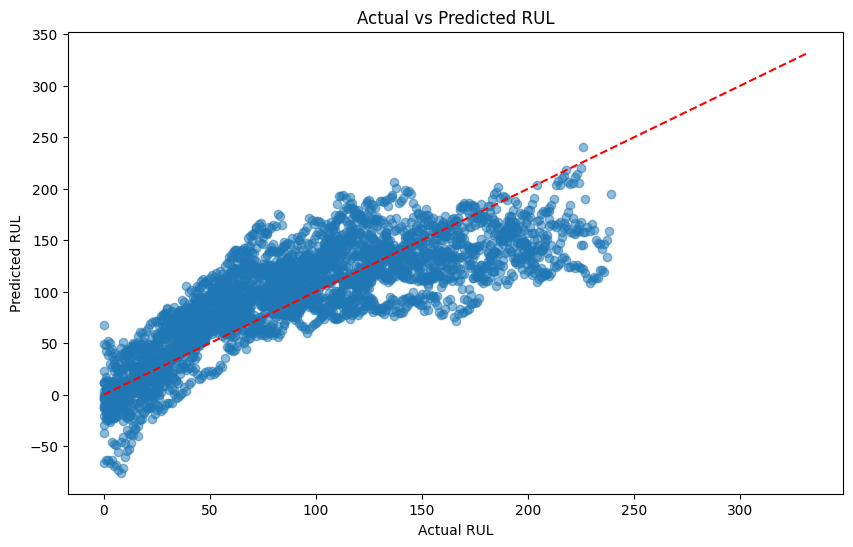

In [190]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

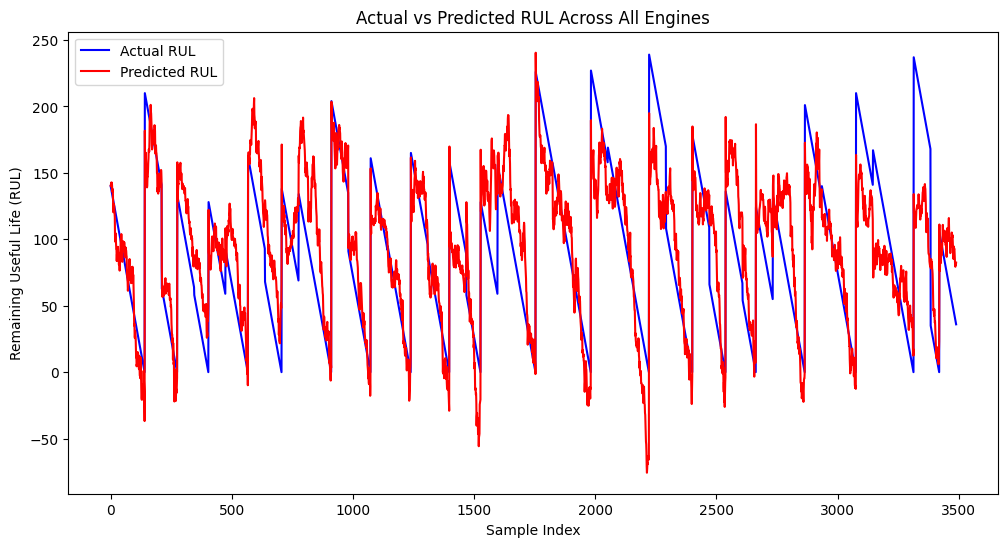

In [191]:
results_df = pd.DataFrame({
    'Actual RUL': y_test,
    'Predicted RUL': y_pred
})
# Reset the index to ensure sequential ordering
results_df = results_df.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual RUL'], label='Actual RUL', color='blue')
plt.plot(results_df['Predicted RUL'], label='Predicted RUL', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL Across All Engines')
plt.legend()
plt.show()

# Training LSTM

In [9]:
# LSTM
lstm_model = Sequential()

# CNN layers for spatial feature extraction
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_columns))))
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2))  # Downsampling to reduce the sequence length
lstm_model.add(Dropout(0.2))

# LSTM layers for temporal pattern recognition
lstm_model.add(LSTM(units=128, return_sequences=True, activation='tanh'))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, activation='tanh'))
lstm_model.add(Dropout(0.2))

# Fully connected layers
lstm_model.add(Dense(units=96, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(units=128, activation='relu'))
lstm_model.add(BatchNormalization())

# Output layer
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
print(lstm_model.summary())

# Training the Model
history = lstm_model.fit(X, y, 
                         epochs=50, 
                         batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            2752      
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 13, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 13, 128)           0         
                                                        

# Training CNN-LSTM

In [10]:
# CNN-LSTM
# Define the model (CNN-LSTM)
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_columns))))
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=100))
cnn_lstm_model.add(Dense(units=1))

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

print(cnn_lstm_model.summary())

# Training the Model
history = cnn_lstm_model.fit(X, y, 
                    epochs=50, 
                    batch_size=64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 64)            2752      
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 81,205
Trainable params: 81,205
Non-trainable params: 0
__________________________________________________

# Training Bi-LSTM

In [11]:
 # Define the model
bi_lstm_model = Sequential()

# Bidirectional LSTM layers
bi_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh'), input_shape=(sequence_length, len(feature_columns))))
bi_lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh')))
bi_lstm_model.add(Bidirectional(LSTM(units=32, activation='tanh')))

# Fully connected layers
bi_lstm_model.add(Dense(units=96, activation='relu'))
bi_lstm_model.add(Dense(units=128, activation='relu'))

# Output layer
bi_lstm_model.add(Dense(units=1))

# Compile the model
bi_lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = bi_lstm_model.fit(X, y, 
                           epochs=15, 
                        #    validation_data=(processed_val_data, processed_val_targets),
                           batch_size=64, 
                           verbose=2)


Epoch 1/15
222/222 - 18s - loss: 2273.7629 - 18s/epoch - 83ms/step
Epoch 2/15
222/222 - 14s - loss: 516.9772 - 14s/epoch - 63ms/step
Epoch 3/15
222/222 - 14s - loss: 444.0169 - 14s/epoch - 63ms/step
Epoch 4/15
222/222 - 14s - loss: 397.9056 - 14s/epoch - 64ms/step
Epoch 5/15
222/222 - 14s - loss: 390.3288 - 14s/epoch - 64ms/step
Epoch 6/15
222/222 - 14s - loss: 369.8503 - 14s/epoch - 65ms/step
Epoch 7/15
222/222 - 14s - loss: 362.4412 - 14s/epoch - 65ms/step
Epoch 8/15
222/222 - 14s - loss: 337.9301 - 14s/epoch - 65ms/step
Epoch 9/15
222/222 - 15s - loss: 268.7697 - 15s/epoch - 65ms/step
Epoch 10/15
222/222 - 15s - loss: 229.7971 - 15s/epoch - 65ms/step
Epoch 11/15
222/222 - 14s - loss: 219.0186 - 14s/epoch - 64ms/step
Epoch 12/15
222/222 - 14s - loss: 199.8089 - 14s/epoch - 64ms/step
Epoch 13/15
222/222 - 14s - loss: 201.7148 - 14s/epoch - 64ms/step
Epoch 14/15
222/222 - 14s - loss: 194.7641 - 14s/epoch - 64ms/step
Epoch 15/15
222/222 - 14s - loss: 179.6885 - 14s/epoch - 64ms/step


# Validation of Models

In [12]:
# Prepping validation data
X_test = []
y_test = []

for engine_id in validation_data['engine_id'].unique():
    engine_data = validation_data[validation_data['engine_id'] == engine_id].reset_index(drop=True)
    for i in range(sequence_length, len(engine_data)):
        # Extract sequence of sensor readings
        seq_x = engine_data[feature_columns].iloc[i - sequence_length:i].values
        X_test.append(seq_x)
        # Extract the target value at the end of the sequence -> PWRUL in this case
        seq_y = engine_data['PWRUL'].iloc[i]  
        y_test.append(seq_y)

X_test = np.array(X_test)
y_test = np.array(y_test)

### Validating LSTM

In [13]:
from sklearn.metrics import mean_squared_error
# Validation with LSTM
lstm_validation_y_test_pred = lstm_model.predict(X_test)
lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, lstm_validation_y_test_pred))
lstm_validation_rmse

109/109 [==============================] - 1s 8ms/step


15.601586002254862

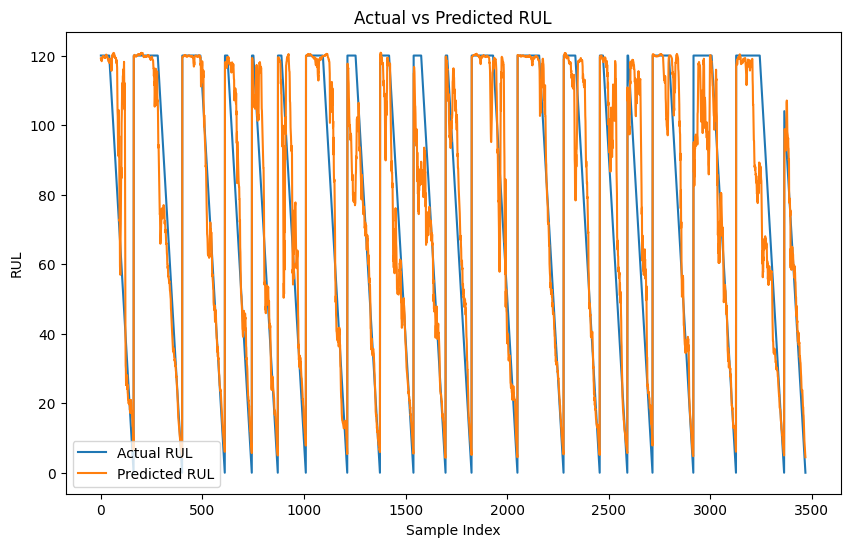

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(lstm_validation_y_test_pred, label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

### Validating Bi-LSTM

In [15]:
from sklearn.metrics import mean_squared_error
# Validation with Bi-LSTM
bi_lstm_validation_y_test_pred = bi_lstm_model.predict(X_test)
bi_lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, bi_lstm_validation_y_test_pred))
bi_lstm_validation_rmse

109/109 [==============================] - 2s 11ms/step


12.951325444854325

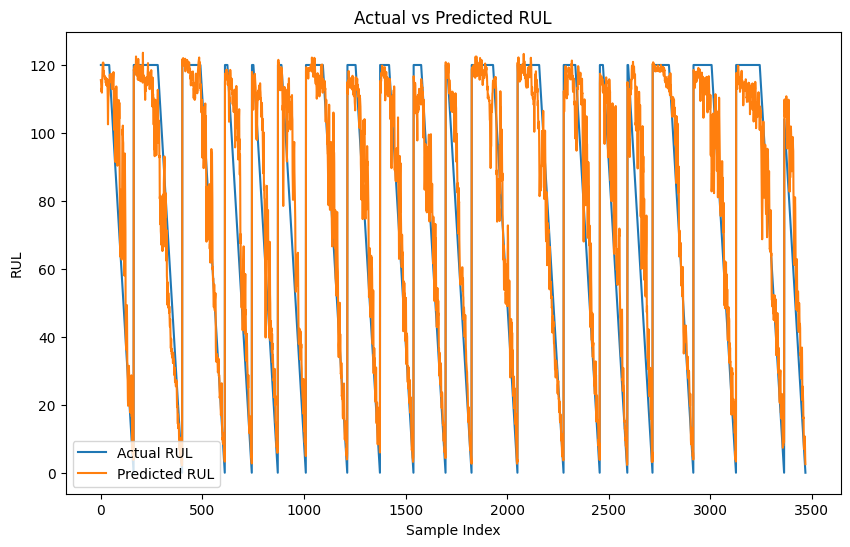

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(bi_lstm_validation_y_test_pred, label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

### Validating CNN-LSTM

In [17]:
from sklearn.metrics import mean_squared_error
# Validation with CNN-LSTM
cnn_lstm_validation_y_test_pred = cnn_lstm_model.predict(X_test)
cnn_lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, cnn_lstm_validation_y_test_pred))
cnn_lstm_validation_rmse

109/109 [==============================] - 0s 2ms/step


12.942826478496809

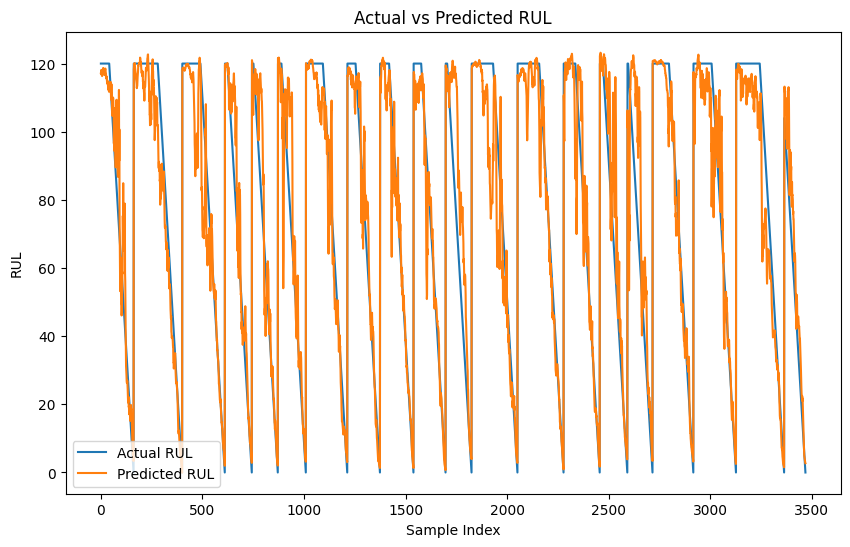

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(cnn_lstm_validation_y_test_pred, label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

# Testing Models on Test Data

In [19]:
# Prepping test data
X_test = []
y_test = []

for engine_id in test_df_normalized['engine_id'].unique():
    engine_data = test_df_normalized[test_df_normalized['engine_id'] == engine_id].reset_index(drop=True)
    if len(engine_data) >= sequence_length:
        # Use only the last sequence
        seq_x = engine_data[feature_columns].iloc[-sequence_length:].values
        X_test.append(seq_x)
        # Get the true RUL for this engine
        seq_y = true_rul.loc[engine_id - 1].values[0]
        y_test.append(seq_y)
    else:
        print(f"Engine {engine_id} has insufficient data for the defined sequence length.")

X_test = np.array(X_test)
y_test = np.array(y_test)

In [20]:
from sklearn.metrics import mean_squared_error

## Predict with LSTM

In [21]:
y_test_pred = lstm_model.predict(X_test)
lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
lstm_testing_rmse

4/4 [==============================] - 0s 4ms/step


18.652726396532167

4/4 [==============================] - 0s 4ms/step


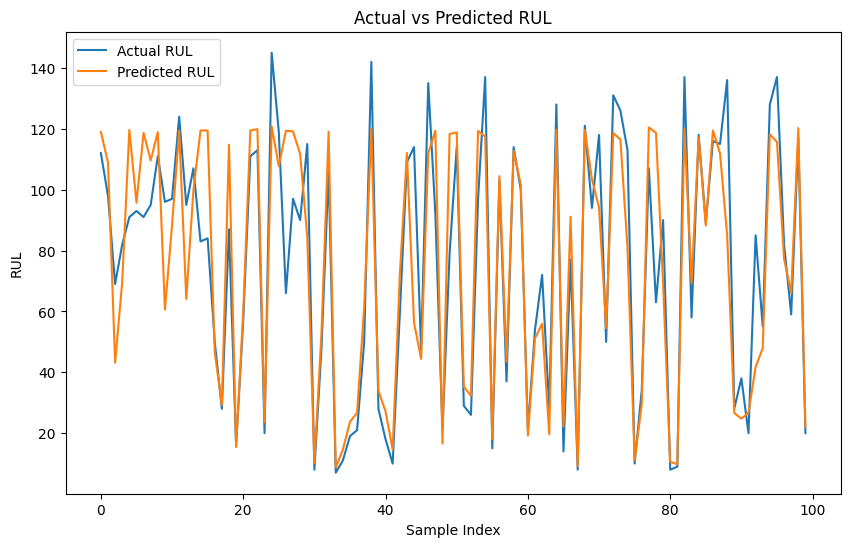

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

## Predict with Bi-LSTM

In [23]:
y_test_pred = bi_lstm_model.predict(X_test)
bi_lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
bi_lstm_testing_rmse

4/4 [==============================] - 0s 8ms/step


14.912737758712112

4/4 [==============================] - 0s 8ms/step


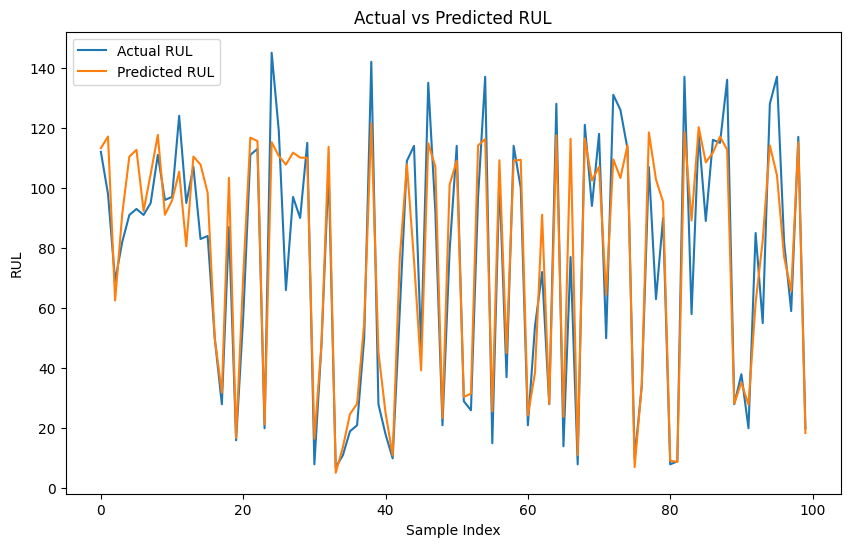

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(bi_lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

## Predict with CNN-LSTM

In [25]:
y_test_pred = cnn_lstm_model.predict(X_test)
cnn_lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cnn_lstm_testing_rmse

4/4 [==============================] - 0s 2ms/step


14.076488091936586

4/4 [==============================] - 0s 3ms/step


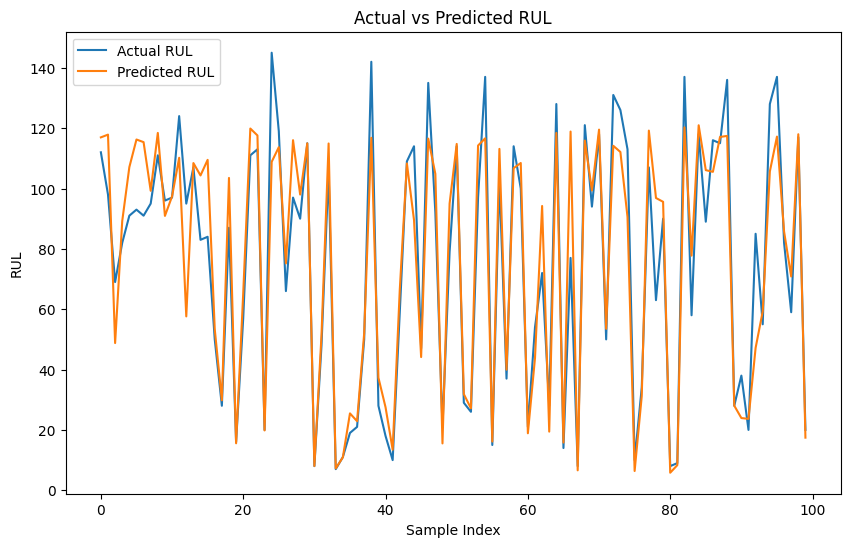

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(cnn_lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

# Comparison Between Validation and Testing

In [27]:
import pandas as pd

# Create a dictionary with the results
results = {
    'Model': ['LSTM', 'CNN-LSTM', 'Bi-LSTM'],
    'Validation RMSE': [lstm_validation_rmse, cnn_lstm_validation_rmse, bi_lstm_validation_rmse],
    'Testing RMSE': [lstm_testing_rmse, cnn_lstm_testing_rmse, bi_lstm_testing_rmse]
}

# Create the DataFrame
results_df = pd.DataFrame(results)

# Set 'Model' as the index for better presentation
results_df.set_index('Model', inplace=True)

# Display the table
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
          Validation RMSE  Testing RMSE
Model                                  
LSTM            15.601586     18.652726
CNN-LSTM        12.942826     14.076488
Bi-LSTM         12.951325     14.912738


# Saving of Scale & Models

In [38]:
# MinMaxScaler
import pickle
with open('./scale/minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [39]:
# Saving LSTM Model
lstm_model.save('./models/lstm_model.h5')

In [40]:
# Saving Bi-LSTM Model
bi_lstm_model.save('./models/bi_lstm_model.h5')

In [41]:
# Saving CNN-lstm Model
cnn_lstm_model.save('./models/cnn_lstm_model.h5')

# Loading Model Instead of Retraining

In [42]:
import pickle

with open('./scale/minmax_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [43]:
from tensorflow.keras.models import load_model

lstm_model = load_model('./models/lstm_model.h5')
bi_lstm_model = load_model('./models/bi_lstm_model.h5')
cnn_lstm_model = load_model('./models/cnn_lstm_model.h5')

In [34]:
# Run Prepping of Testing Data Block on Top

# Ensemble
- Simple Average
- Weighted (?) -> giving weights to each of the model
- Stacking Ensemble

## Simple Average Ensemble

In [44]:
# Make predictions on the test set with each model
y_pred_lstm = lstm_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)
y_pred_bi_lstm = bi_lstm_model.predict(X_test)

# Reshape predictions if necessary
y_pred_lstm = y_pred_lstm.flatten()
y_pred_cnn_lstm = y_pred_cnn_lstm.flatten()
y_pred_bi_lstm = y_pred_bi_lstm.flatten()

# Simple average of predictions
y_pred_ensemble = (y_pred_lstm + y_pred_cnn_lstm + y_pred_bi_lstm) / 3

# Evaluate ensemble performance
from sklearn.metrics import mean_squared_error

rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
print(f'Ensemble RMSE (Simple Average): {rmse_ensemble:.2f}')

4/4 [==============================] - 1s 8ms/step
Ensemble RMSE (Simple Average): 13.93


## Stacking Ensemble
- Must split the training data to get teh validation set
- Validation set is used to train the meta model

In [36]:
meta_features_val = np.column_stack((y_pred_lstm, y_pred_cnn_lstm, y_pred_bi_lstm))
meta_target_val = y_test

In [37]:
# The following is wrong because we should have used the base lstm, cnn-lstm, bi-lstm models to predict validation set
# Used the validation set result to fit the linear regression
from sklearn.linear_model import LinearRegression

# Initialize the meta-model
meta_model = LinearRegression()

# Train the meta-model on the validation set predictions
meta_model.fit(meta_features_val, meta_target_val)

LinearRegression()